In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/72_8.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

178.257660866


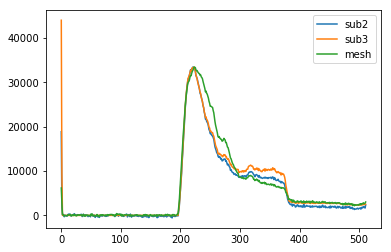

In [4]:
EID = 200
t1 = PSAdf.iloc[EID,3:].values
sub1 = ADCdf[ADCdf['EventID']==EID]
sub2 = sub1.iloc[:,3:][sub1.iloc[:,3:].max(axis=1)>100].sum(axis=0).values
sub3 = sub1.iloc[:,3:][sub1.iloc[:,3:]>20].sum(axis=0).values
#plt.plot(sub2)
#plt.plot(sub1.iloc[:,3:].sum(axis=0).values,c='r')
#plt.plot(sub3,c='b')

plt.plot(sub2/max(sub2[10:-10])*max(t1[10:-10]),label='sub2')
plt.plot(sub3/max(sub3[10:-10])*max(t1[10:-10]),label='sub3')
#plt.plot(t1)
plt.plot(t1,label='mesh')
plt.legend()

In [5]:
def GetT0(EID):
    sub1 = ADCdf[ADCdf['EventID']==EID]
    mesh = sub1.iloc[:,3:][sub1.iloc[:,3:]>20].sum(axis=0).values
    mesh_convol = np.convolve(mesh,([1]*10)[::-1],'same')
    mesh_convol_grad = np.gradient(mesh_convol.real)
    indexes = peakdetect(mesh_convol_grad,lookahead=10,delta=10)
    pl = indexes[1]+indexes[0]
    mp = max(np.abs(zip(*pl)[1]))
    pl = [(x,y) for x,y in pl if abs(y)>0.08*mp and y<0]
    return sorted(pl,key=lambda x:x[0])[-1][0]
    #plt.plot(mesh*0.5)
    #plt.plot(mesh_convol_grad)
    #plt.plot(zip(*pl)[0],zip(*pl)[1],'+',c='r')
#plt.legend()
#print ADCdf['EventID'].unique()
t0hist = {'EventID':[],'t0':[]}
for i in ADCdf['EventID'].unique():
    t0 = -100
    try:
        t0 = GetT0(i)
    except:
        pass
    if t0<10:
        t0hist['t0'].append(np.nan)
    else:
        t0hist['t0'].append(t0)
    t0hist['EventID'].append(i)
t0df = pd.DataFrame(t0hist)

def GetT0Plot(EID):
    print EID
    sub1 = ADCdf[ADCdf['EventID']==EID]
    mesh_raw = sub1.iloc[:,3:].sum(axis=0).values
    mesh = sub1.iloc[:,3:][sub1.iloc[:,3:].abs()>20].sum(axis=0).values
    mesh_convol = np.convolve(mesh,([1]*10)[::-1],'same')
    mesh_convol_grad = np.gradient(mesh_convol.real)
    indexes = peakdetect(mesh_convol_grad,lookahead=10,delta=10)
    #pl = indexes[1]+indexes[0]
    #mp = max(np.abs(zip(*pl)[1]))
    #pl = [(x,y) for x,y in pl if abs(y)>0.08*mp and y<0]
    #print sorted(pl,key=lambda x:x[0])[-1][0]
    plt.clf()
    plt.plot(mesh_raw[10:-10]*0.3,label="raw")
    plt.plot(mesh[10:-10]*0.5,label="mesh")
    plt.plot(mesh_convol_grad[10:-10],label="grad")
    plt.legend()
    plt.savefig('pics/'+str(EID)+".png")
    #plt.plot(zip(*pl)[0],zip(*pl)[1],'+',c='r')
tmp = t0df[t0df['t0'].isnull()] 
for i in tmp['EventID']:
    GetT0Plot(i)

(300, 500)

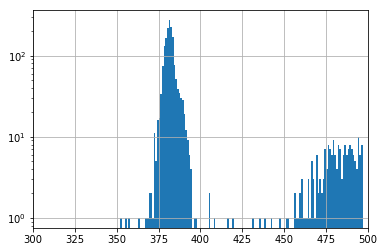

In [6]:
t0df['t0'].hist(bins = np.arange(0,512,1))
plt.gca().set_yscale('log')
plt.gca().set_xlim([300,500])

In [7]:
#t0df.to_csv('72_8_t0.csv',index=False)